# Variational Dropout - (probably) the simplest Bayesian DL algorithm ever.

One of the simplest examples of Bayesian DL is a technique called [Variational Dropout](https://arxiv.org/pdf/1506.02142.pdf). This technique makes an extensive usage of a [Dropout technique](http://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf) from which introduction we will start first:

## Vanila Dropout

![Visualization of unit drop in dropout technique](example_images/variational_dropout/dropout.png)

The dropout technique applied to batch training consists of the following steps:
1. Multiply each activation unit $a$ by a sample from independent Bernouli distributions $B(p_a)$.
2. Perform _forward_ and _backward_ passes of neural network with masked activations.

The same technique can be also applied to weights.

### Let's have a look how it works

Let us introduce a dummy dataset:

In [1]:
import matplotlib.pyplot as plt

from examples import DummyDatasetForRegression


POINTS_PER_BLOB = 100
SCALE = 0.6


dummy_dataset_for_regression = DummyDatasetForRegression(
    points_per_blob=POINTS_PER_BLOB,
    scale=SCALE,
)
dummy_dataset_for_regression.visualize_dataset()
plt.show()

<Figure size 700x600 with 2 Axes>

Now - let us introduce a simple model for regression:

In [2]:
from keras import models
from keras import layers

ACTIVATION='relu'
EPOCHS=100

def build_simple_model(layer_size=200, activation='relu'):
    input_to_model = layers.Input(shape=(1,))
    aux_layer = input_to_model
    aux_layer = layers.Dense(layer_size, activation=activation)(aux_layer)
    aux_layer = layers.Dense(layer_size, activation=activation)(aux_layer)
    output = layers.Dense(1)(aux_layer)
    
    model_ = models.Model(input_to_model, output)
    model_.compile(loss='mse', optimizer='adam')
    return model_

model = build_simple_model(activation=ACTIVATION)
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               400       
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 201       
Total params: 40,801
Trainable params: 40,801
Non-trainable params: 0
_________________________________________________________________


Now - we can fit a model to check what has it learnt:

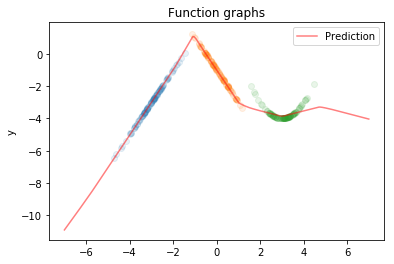

In [3]:
full_dataset = dummy_dataset_for_regression.full_dataset
simple_history = model.fit(full_dataset.x, full_dataset.y, epochs=EPOCHS, verbose=0)
dummy_dataset_for_regression.visualize_model(model=model)

### Variational Dropout

Variational Dropout technique in it's vanila version is simply to leave masking of neurons also during the inference time. 

Let's have a look how it might be implemented in `keras`:

In [4]:
import keras.backend as K


def build_dropout_model(layer_size=200, dropout_rate=0.5, activation='relu'):
    input_to_model = layers.Input(shape=(1,))
    aux_layer = input_to_model
    aux_layer = layers.Dense(layer_size, activation=activation)(aux_layer)
    aux_layer = layers.Lambda(lambda x: K.dropout(x, dropout_rate))(aux_layer)
    aux_layer = layers.Dense(layer_size, activation=activation)(aux_layer)
    aux_layer = layers.Lambda(lambda x: K.dropout(x, dropout_rate))(aux_layer)
    output = layers.Dense(1)(aux_layer)
    
    model_ = models.Model(input_to_model, output)
    model_.compile(loss='mse', optimizer='adam')
    return model_

dropout_model = build_dropout_model(activation=ACTIVATION)
dropout_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 200)               400       
_________________________________________________________________
lambda_1 (Lambda)            (None, 200)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 200)               40200     
_________________________________________________________________
lambda_2 (Lambda)            (None, 200)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 201       
Total params: 40,801
Trainable params: 40,801
Non-trainable params: 0
_________________________________________________________________


Now - let's train the model:

In [5]:
simple_dropout_history = dropout_model.fit(
    x=full_dataset.x,
    y=full_dataset.y, 
    epochs=EPOCHS,
    verbose=0,
)

And visualize its results:

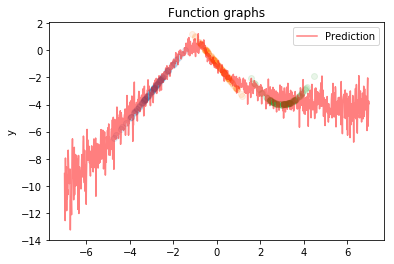

In [6]:
dummy_dataset_for_regression.visualize_model(model=dropout_model)

Beside of that - we can check how samples are distributed:

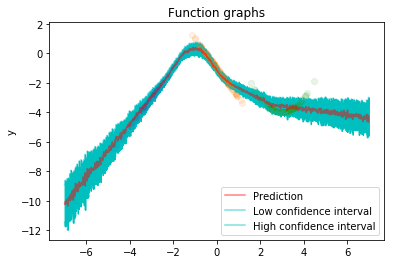

In [7]:
dummy_dataset_for_regression.visualize_variational_model(model=dropout_model, nb_of_samples=50)

Now - you can play around with `POINTS_PER_BLOB` size. Do the confidence interval change? Why?

![Visualization of unit drop in dropout technique](example_images/variational_dropout/dropout_lemma.png)
This piece comes from [Randomized Prior Functions
for Deep Reinforcement Learning, Osband et al.](https://arxiv.org/pdf/1806.03335.pdf)

This is pretty obvious why - unless Variational Dropout does not have learnable distributional parameters - it will suffer from this problem. One possible solution? 

### Concrete Dropout

There are many ways on how one can train a dropout rate. One possible way is to use the following alternated `sigmoid` activation:

$$S' = sigmoid\left(\frac{1}{t}\left(\log p - \log(1-p) + \log u - log(1 -u)\right)\right),$$

where $u \sim Unif(0, 1)$. This is the way how the function was presented in [original Concrete Dropout](https://arxiv.org/pdf/1705.07832.pdf) paper. But if we introduce another function:

$$sigmoid^{-1}(p) = \log p - \log 1 - p,$$

which is the actual inverse function of $sigmoid$ - the new activation might be presented in a slightly more understandable manner:

$$S'(p) = sigmoid\left(\frac{1}{t}\left(sigmoid^{-1}(p) + sigmoid^{-1}(u)\right)\right),$$

Let's have a look at `concrete_sigmoid` function - how it behaves and how it might simulate dropout sampling:

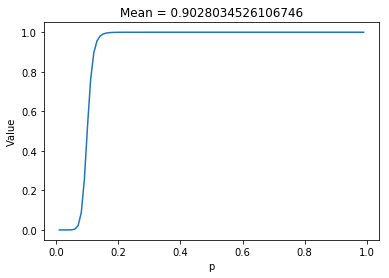

In [8]:
from utils import plot_concrete_sigmoid

TEMPERATURE = 0.1
P = 0.9
STEPS = 100

plot_concrete_sigmoid(p=P, t=TEMPERATURE, step=STEPS)

So - as one may see - this function might be treated as differentiable sampling.

There was no $prior$ component in Variational Dropout (why?). In case of Concrete Dropout the following regularization is used:

$$KL\left(q_M(W)|p(W)\right) = \frac{l(1 - p)}{2} \lVert M \rVert_2^2 - K\mathcal{H}(p),$$

where: 

- $M$ is layer weights matrices,
- $\mathcal{H}$ is entropy,
- $p$ is predicted dropout rate.

Now - let's use the authors implementation in order to have fun with the Concrete Dropout:

In [9]:
from concrete_dropout import ConcreteDropout

def build_concrete_dropout_model(layer_size=200, activation=ACTIVATION):
    input_to_model = layers.Input(shape=(1,))
    aux_layer = input_to_model
    aux_layer = ConcreteDropout(layers.Dense(layer_size, activation=ACTIVATION))(aux_layer)
    aux_layer = ConcreteDropout(layers.Dense(layer_size, activation=ACTIVATION))(aux_layer)
    output = layers.Dense(1)(aux_layer)
    
    model_ = models.Model(input_to_model, output)
    model_.compile(loss='mse', optimizer='adam')
    return model_

concrete_dropout_model = build_concrete_dropout_model()

Now - let's train it:

In [10]:
concrete_dropout_history = concrete_dropout_model.fit(
    x=full_dataset.x,
    y=full_dataset.y,
    epochs=EPOCHS,
    verbose=0,
)

And see how it works:

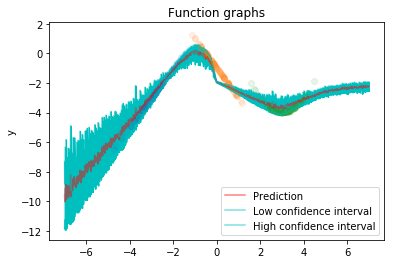

In [11]:
dummy_dataset_for_regression.visualize_variational_model(model=concrete_dropout_model, nb_of_samples=50)

Now - let's compare all of the methods:

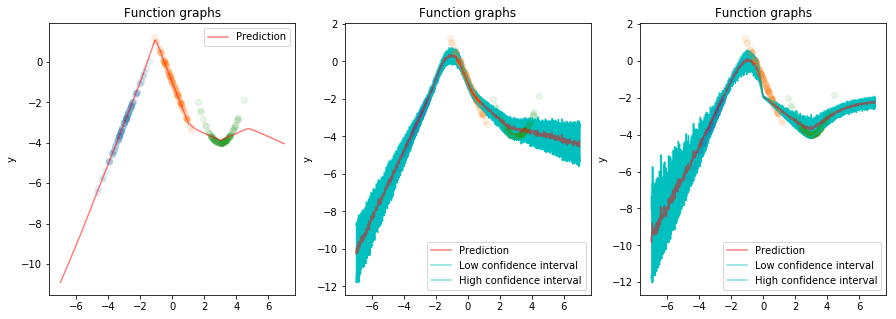

In [12]:
NUMBER_OF_SAMPLES = 100

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title('Dropout model')
dummy_dataset_for_regression.visualize_model(model=model)
plt.subplot(1, 3, 2)
plt.title('Variational Dropout model')
dummy_dataset_for_regression.visualize_variational_model(
    model=dropout_model, 
    nb_of_samples=NUMBER_OF_SAMPLES,
)
plt.subplot(1, 3, 3)
plt.title('Concrete dropout model')
dummy_dataset_for_regression.visualize_variational_model(
    model=concrete_dropout_model, 
    nb_of_samples=NUMBER_OF_SAMPLES,
)